# Tabular Neural Network

In [1]:
#  Import libraries
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Preprocessed Data
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_train_encoded_scaled.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/X_test_encoded_scaled.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_train.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/y_test.csv").squeeze()

In [4]:
# Check input shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (182690, 8)
y_train shape: (182690,)


In [5]:
# Get number of features and classes
num_features = X_train.shape[1]
num_classes = len(set(y_train))

# Build baseline MLP
model = keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,371 (40.51 KB)

 Trainable params: 9,987 (39.01 KB)

 Non-trainable params: 384 (1.50 KB)

In [6]:
def glu(x, units):
    """Gated Linear Unit activation."""
    linear = layers.Dense(units)(x)
    gate = layers.Dense(units, activation='sigmoid')(x)
    return layers.Multiply()([linear, gate])

def feature_transformer(x, units):
    """A basic feature transformer block."""
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = glu(x, units)
    return x

def attentive_transformer(x, prior_scales, units):
    """Attentive transformer block for feature selection."""
    mask_logits = layers.Dense(units)(x)
    mask = layers.Activation('softmax')(mask_logits)  # Use sparsemax for true TabNet if you implement it!
    mask = layers.Multiply()([mask, prior_scales])
    return mask

def tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=3):
    prior = layers.Lambda(lambda x: K.ones_like(x))(inputs)  # Start with "all features allowed"
    masked_features = inputs
    step_outputs = []

    for step in range(num_steps):
        # Feature transformer
        x = feature_transformer(masked_features, feature_dim)
        # Attentive transformer to produce feature mask
        mask = attentive_transformer(x, prior, inputs.shape[-1])
        # Update masked features
        masked_features = layers.Multiply()([inputs, mask])
        # Decision output for this step
        out = layers.Dense(feature_dim, activation='relu')(masked_features)
        step_outputs.append(out)
        # Update prior (discourage re-selection)
        prior = layers.Multiply()([prior, layers.Lambda(lambda x: 1. - x)(mask)])

    # Aggregate outputs (TabNet does a weighted sum)
    final_out = layers.Add()(step_outputs)
    final_out = layers.Dense(output_dim, activation='softmax')(final_out)
    return final_out

In [7]:
# Main Model
num_features = X_train.shape[1]
num_classes = len(set(y_train))

inputs = Input(shape=(num_features,))
outputs = tabnet_block(inputs, num_steps=3, feature_dim=64, output_dim=num_classes)

tabnet_model = Model(inputs=inputs, outputs=outputs)
tabnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
tabnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │        576 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64)        │          0 │ dense_4[0][0],    │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        520 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 8)         │          0 │ dense_6[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8)         │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 8)         │          0 │ activation[0][0], │
│ (Multiply)          │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 8)         │          0 │ input_layer_1[0]… │
│ (Multiply)          │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │        576 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 64)        │          0 │ dense_9[0][0],    │
│ (Multiply)          │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8)         │        520 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8)         │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8)         │          0 │ dense_11[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 8)         │          0 │ lambda[0][0],     │
│ (Multiply)          │                   │            │ lambda_1[0][0]  

 Total params: 30,939 (120.86 KB)

 Trainable params: 30,555 (119.36 KB)

 Non-trainable params: 384 (1.50 KB)

In [8]:
history = tabnet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,    # Adjust as needed
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.6724 - loss: 0.7650 - val_accuracy: 0.7597 - val_loss: 0.5734
Epoch 2/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7609 - loss: 0.5577 - val_accuracy: 0.7729 - val_loss: 0.5270
Epoch 3/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7695 - loss: 0.5245 - val_accuracy: 0.7703 - val_loss: 0.5160
Epoch 4/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7726 - loss: 0.5111 - val_accuracy: 0.7727 - val_loss: 0.5040
Epoch 5/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7751 - loss: 0.4991 - val_accuracy: 0.7821 - val_loss: 0.4881
Epoch 6/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7784 - loss: 0.4874 - val_accuracy: 0.7792 - val_loss: 0.4828
Epoch 7/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7780 - loss: 0.4823 - val_accuracy: 0.7791 - val_loss: 0.4765
Epoch 8/20
714/714 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7817 - loss: 0.4745 - val_accuracy: 

In [9]:
y_pred = tabnet_model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     31061
           1       0.77      0.78      0.77     26318
           2       0.75      0.78      0.77     20917

    accuracy                           0.79     78296
   macro avg       0.78      0.79      0.78     78296
weighted avg       0.79      0.79      0.79     78296



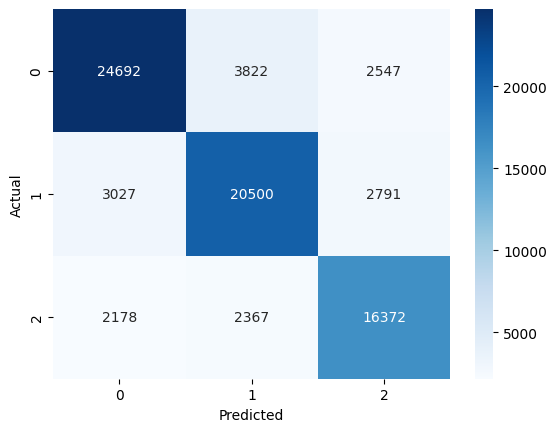

In [10]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2447/2447 ━

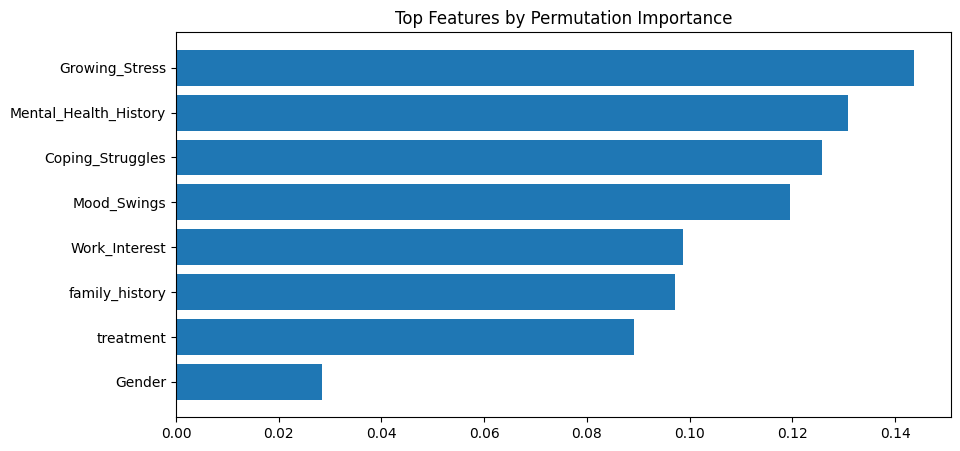

In [11]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=5):
    baseline = metric(y, model.predict(X).argmax(axis=1))
    importances = []
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(y, model.predict(X_permuted).argmax(axis=1))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

# Usage:
X_test_np = X_test.values if hasattr(X_test, "values") else X_test  # ensure it's a numpy array
importances = permutation_importance(tabnet_model, X_test_np, y_test)

# Plot top features
import matplotlib.pyplot as plt
feature_names = X_test.columns
top_idx = np.argsort(importances)[-10:]
plt.figure(figsize=(10,5))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.title("Top Features by Permutation Importance")
plt.show()

## Top Feature Interpretations – Global Model View (Permutation Importance)

| **Feature**               | **Interpretation**                                                                                                                               |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **Growing_Stress**        | Most influential predictor. Sustained or rising stress levels significantly impact risk classification, underscoring stress as a core signal.   |
| **Mental_Health_History** | Strong indicator. A personal history of mental health issues consistently raises risk levels, in line with clinical expectations.               |
| **Coping_Struggles**      | Highly predictive. Difficulty coping with daily challenges reflects emotional vulnerability and instability.                                    |
| **Mood_Swings**           | Important behavioral signal. Frequent mood changes are closely associated with elevated mental health risk.                                    |
| **Work_Interest**         | Meaningful contributor. Lack of motivation or work disengagement often signals early distress or burnout.                                      |
| **family_history**        | Moderately predictive. A family history of mental illness reinforces individual risk patterns.                                                  |
| **treatment**             | Slightly predictive. Treatment history may indicate previous or ongoing challenges but is less dominant than active behavioral markers.         |
| **Gender**                | Least influential among top features. Minor demographic predictor with limited direct impact compared to psychological factors.                |

---

### Interpretation
The global permutation importance chart shows that **behavioral and psychological features**, especially stress levels, mental health history, and coping ability, are the most critical for predicting risk. Mood instability and disengagement from work also contribute significantly. In contrast, **static demographic variables** such as gender have a minimal effect.

---

### Summary
This model emphasizes **real-time mental state and behavioral patterns** as core drivers of mental health risk classification. Interventions focusing on stress management, emotional regulation, and coping skills are supported by these insights. Demographic traits play a secondary role, reinforcing the need for dynamic, personalized mental health assessments.

2447/2447 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


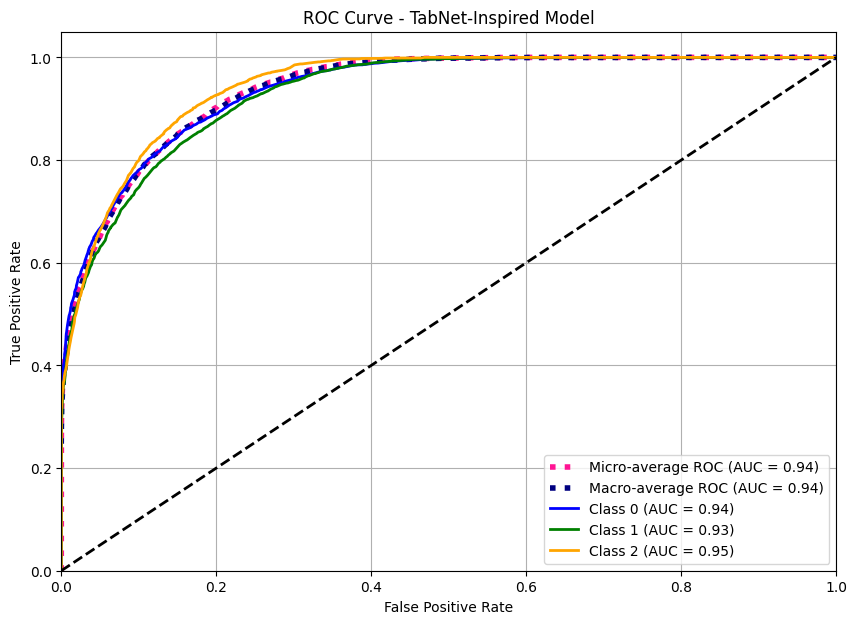

In [13]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_score = tabnet_model.predict(X_test)  # shape: (n_samples, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Micro
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})",
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

colors = ['blue', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - TabNet-Inspired Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Model Evaluation Summary (TabNet-Inspired Model)

| **Metric**                   | **Value** | **Comment**                                                                 |
|------------------------------|-----------|------------------------------------------------------------------------------|
| **Accuracy**                 | 0.79      | Solid overall performance with some overlap between adjacent risk classes   |
| **Precision (macro avg)**    | 0.78      | Indicates consistent precision across all classes                           |
| **Recall (macro avg)**       | 0.79      | High sensitivity, capturing most relevant cases across groups               |
| **F1-Score (macro avg)**     | 0.78      | Balanced prediction quality across all classes                              |
| **Precision (weighted avg)** | 0.79      | Adjusted for class imbalance; stable across support distribution            |
| **Recall (weighted avg)**    | 0.79      | Matches accuracy; reflects even recall across larger and smaller classes    |
| **F1-Score (weighted avg)**  | 0.79      | Reflects reliable multiclass classification                                 |
| **ROC AUC (micro-average)**  | 0.94      | Strong overall class discrimination ability                                 |
| **ROC AUC (macro-average)**  | 0.94      | Excellent average class separability                                        |
| **Class 0 AUC**              | 0.94      | Class 0 (Medium Risk) well captured with high discrimination                |
| **Class 1 AUC**              | 0.93      | Class 1 (Low Risk) slightly weaker but still high                           |
| **Class 2 AUC**              | 0.95      | Class 2 (High Risk) is most strongly separated                              |
| **Confusion Matrix**         | Minor off-diagonal confusion                 | Slight overlap between Class 1 and others, especially Class 2               |
| **Feature Importance**       | Growing_Stress, Mental_Health_History, Coping_Struggles, Mood_Swings, Work_Interest | Key behavioral and mental health indicators drive the model’s predictions   |

---

**Interpretation:**  
The TabNet-inspired model achieved 0.79 accuracy with balanced macro-averaged precision, recall, and F1-score around 0.78–0.79. ROC AUC values remain excellent, with 0.94–0.95 across all classes and averages. Most confusion occurs between low and medium risk groups, which is clinically expected. Feature importance highlights stress, mood, and mental health history as the most influential predictors, reaffirming the model's focus on dynamic psychological and behavioral patterns.

In [16]:
# Define path to save model
tabnet_path = '/content/drive/MyDrive/Colab Notebooks/AAI-590/final/models/tabnet_model.keras'

# Save the model in modern format
tabnet_model.save(tabnet_path)

print(f"TabNet model saved to: {tabnet_path}")

TabNet model saved to: /content/drive/MyDrive/Colab Notebooks/AAI-590/final/models/tabnet_model.keras
